 # **Vehicle Detection Project**

TDOD: Write a brief overview of the steps in the project

## **Imports**

In [19]:
import numpy as np
import cv2
import glob
import time


from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale



import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

## **Helper Functions**

In [29]:
def show_img(img, figsize=(20, 20)):
    plt.figure(figsize)
    plt.imshow(img)    

def show_random_imgs(imgs_paths, fig_width = 5, fig_height = 5, title = ''):
    
    fig, axs = plt.subplots(fig_height, fig_width, figsize=(20, 20))
    fig.subplots_adjust(hspace = 0.2,  wspace = 0.01)
    axs = axs.ravel()

    for i in range(fig_width * fig_height):
        random_index = np.random.randint(0, len(imgs_paths))
        img = cv2.imread(imgs_paths[random_index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i].axis('off')
        axs[i].set_title(title, fontsize=10)
        axs[i].imshow(img)


def show_imgs_side_by_side(img1, img2, title_1 = 'Image 1', title_2 = 'Image_2', cmap1 = None, cmap2 = None):
    fig, (axs1, axs2) = plt.subplots(1, 2, figsize = (20, 20))
    
    fig.subplots_adjust(hspace = 0.2, wspace = 0.4)
    
    axs1.imshow(img1, cmap = cmap1)
    axs1.set_title(title_1, fontsize = 25)
    
    axs2.imshow(img2, cmap = cmap2)
    axs2.set_title(title_2, fontsize = 25)
    
    return (axs1, axs2)



    

## **Feature Extraction**
**Note:** These functions are from the Udacity lessons

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis = False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell),
                                  cells_per_block = (cell_per_block, cell_per_block), transform_sqrt = True, 
                                  visualise = vis, feature_vector = feature_vec, block_norm = 'L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell),
                       cells_per_block = (cell_per_block, cell_per_block), transform_sqrt = True, 
                       visualise = vis, feature_vector = feature_vec, block_norm = 'L2-Hys')
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient = 9, pix_per_cell = 8, cell_per_block = 2, hog_channel = 0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis = False, feature_vec = True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis = False, feature_vec = True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

## **Load Data**

In [4]:
training_data_path = '/home/oystein/Projects/CarND-Self-Driving-Car/vehicle-detection-training-data/'
car_imgs_paths = glob.glob(training_data_path + 'vehicles/**/*.png')
noncar_imgs_paths = glob.glob(training_data_path + 'non-vehicles/**/*.png')


print("Number of car images: ", len(car_imgs_paths))
print("Number of non-car images: ", len(noncar_imgs_paths))


Number of car images:  8792
Number of non-car images:  8968


## **Data Visualization**

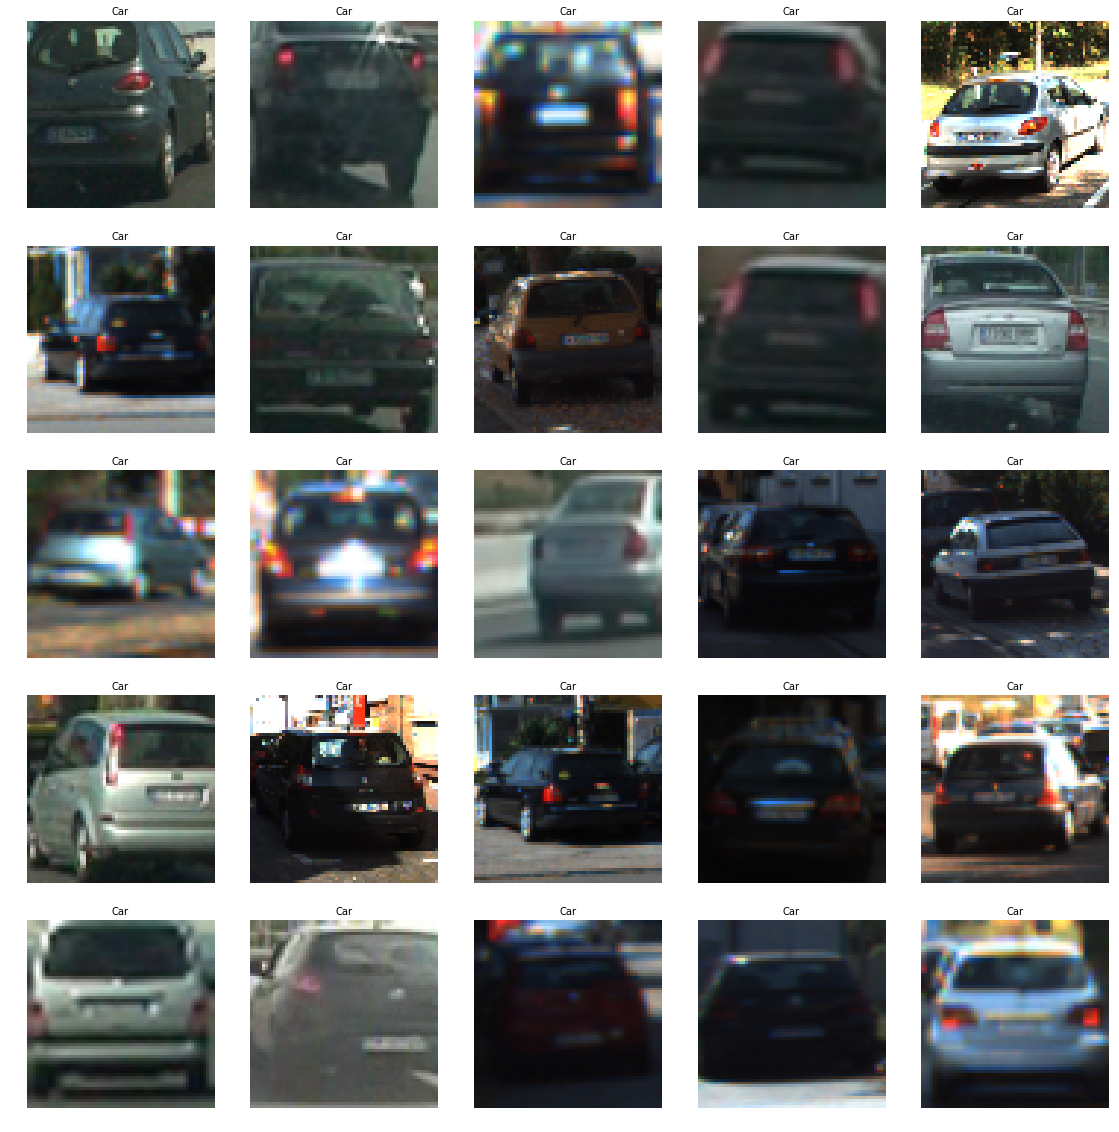

In [5]:
# Take a look at some random car images
show_random_imgs(car_imgs_paths, title = 'Car')



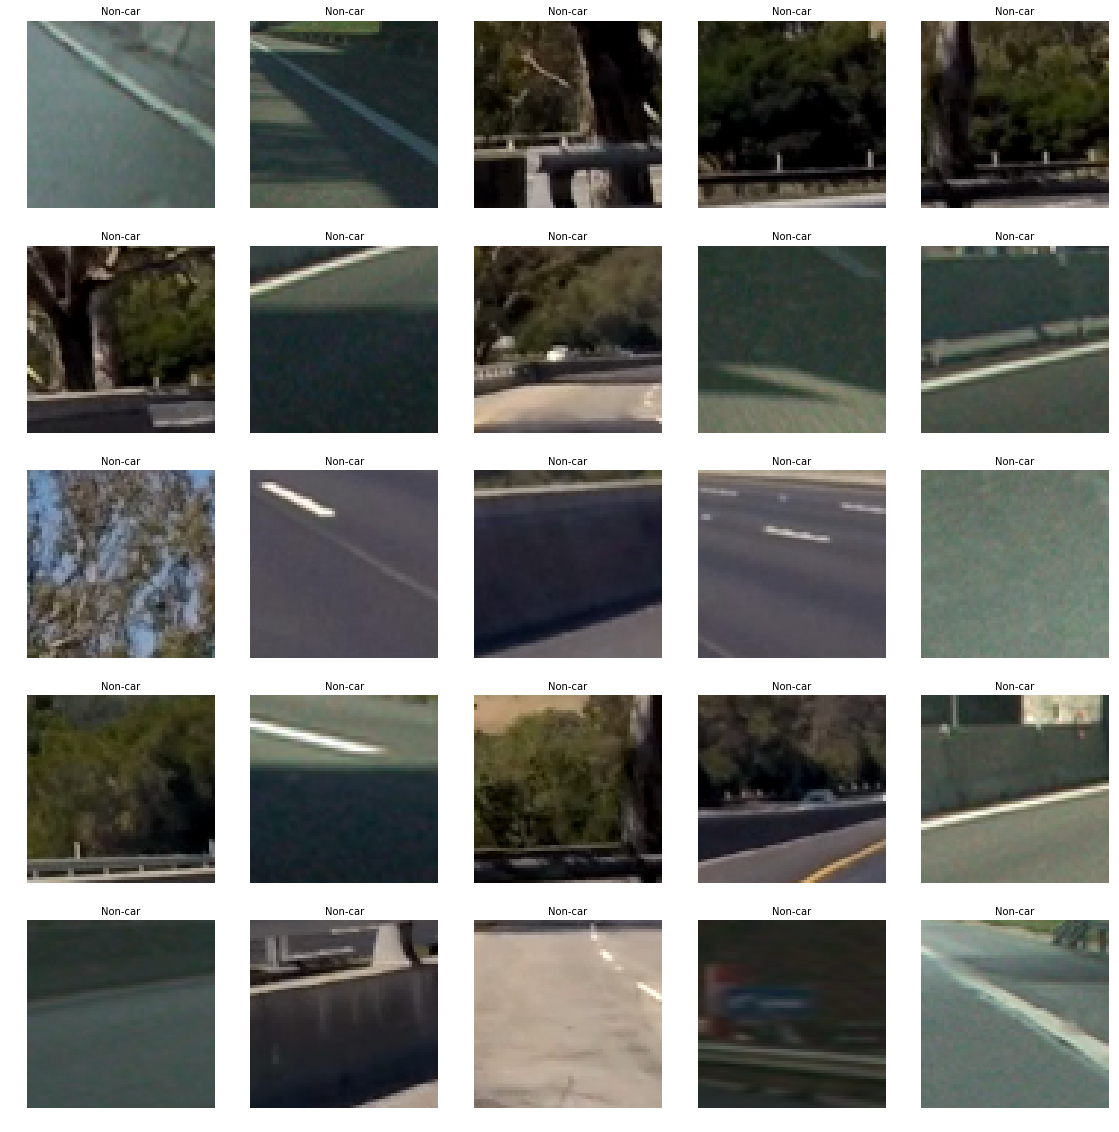

In [6]:
# Take a look at some random non-car imgages
show_random_imgs(noncar_imgs_paths, title = 'Non-car')

## **Feature Extraction For Training a Linear SVM**

(-0.5, 63.5, 63.5, -0.5)

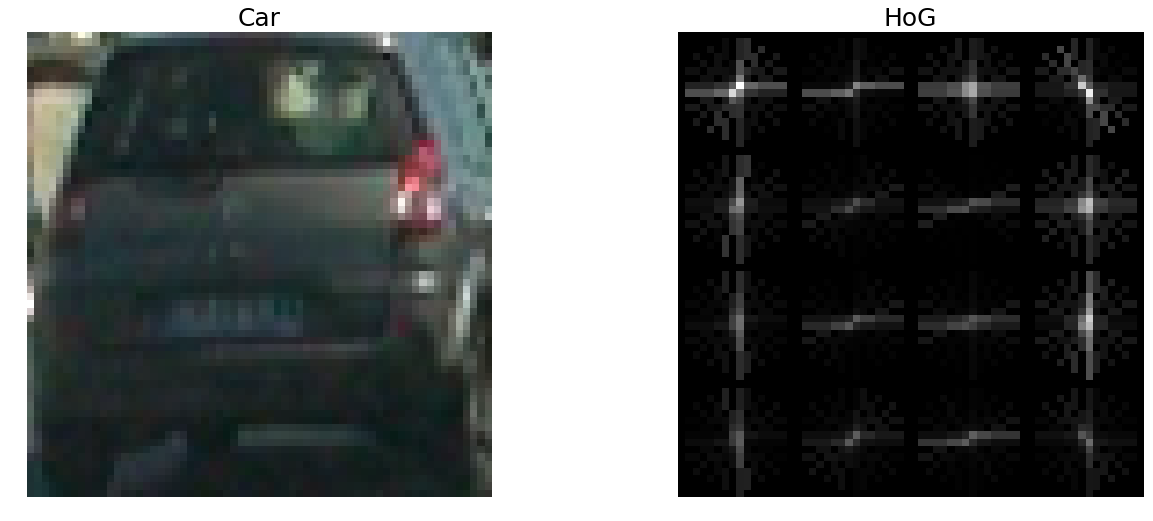

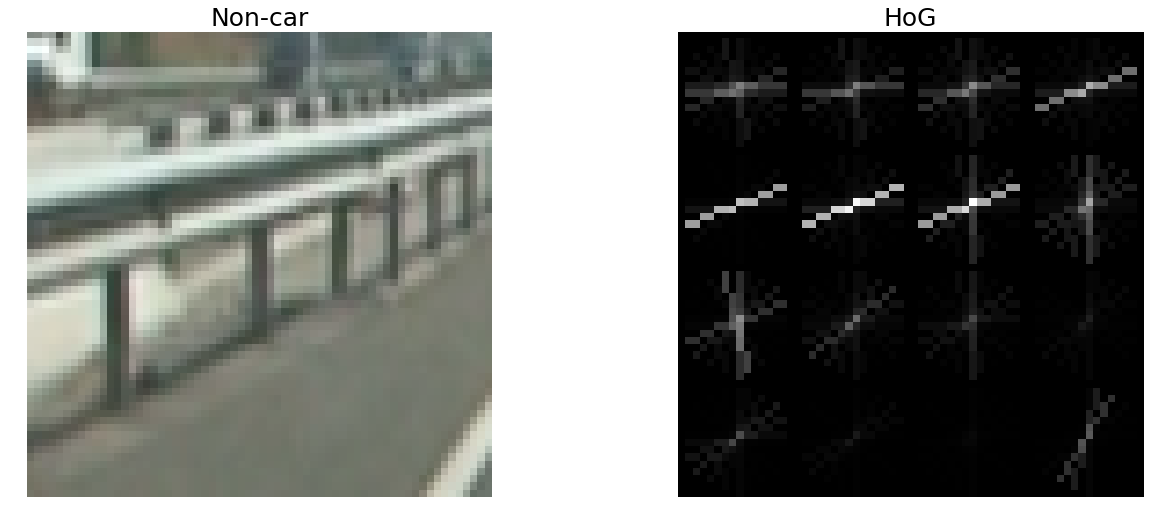

In [11]:
test_image_no = 10

# Get some test images
car_test_img = mpimg.imread(car_imgs_paths[test_image_no])
noncar_test_img = mpimg.imread(noncar_imgs_paths[test_image_no])

# Get HoG features for both images


colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# I'll ignore the feature vector for vizualisation purposes
_, hog_image_car = get_hog_features(car_test_img[:, :, 2], orient, pix_per_cell, cell_per_block, vis = True, feature_vec = False)
_, hog_image_noncar = get_hog_features(noncar_test_img[:, :, 2], orient, pix_per_cell, cell_per_block, vis = True, feature_vec = False)


axs1, axs2, = show_imgs_side_by_side(car_test_img, hog_image_car, title_1 = 'Car', title_2 = 'HoG', cmap1 = None, cmap2 = 'gray')
axs1.axis('off')
axs2.axis('off')

axs1, axs2, = show_imgs_side_by_side(noncar_test_img, hog_image_noncar, title_1 = 'Non-car', title_2 = 'HoG', cmap1 = None, cmap2 = 'gray')
axs1.axis('off')
axs2.axis('off')



In [31]:
car_features = extract_features(car_imgs_paths, cspace = colorspace, orient = orient, 
                        pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                        hog_channel = hog_channel)
noncar_features = extract_features(noncar_imgs_paths, cspace = colorspace, orient = orient, 
                        pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                        hog_channel = hog_channel)


X_raw = np.vstack((car_features, noncar_features)).astype(np.float64)  

X = scale(X_raw)
print("X mean: ", np.mean(X))
print("X std: ", np.std(X))

# Correct answer: 1 for car, 0 for non-car
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Test set is 20% of total data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print("Length of feature vector", len(X_train[0]))


X mean:  -1.96069016508e-16
X std:  1.0
Length of feature vector 1188


## **Train a Linear SVM Classifier**

In [32]:
# Create a linear SVM
svc = LinearSVC()

# Fit to the training data
svc.fit(X_train, y_train)

# Check the score of the SVC
y_pred= svc.predict(X_test)

acc = accuracy_score(y_test, y_pred)

print('Accuracy of test set is: ', acc)






Accuracy of test set is:  0.969031531532
